# Nama  : Abdullah Azam
# NIM   : 2209106056

LINK DATASET  : [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

Pada dataset terdiri dari 5 jenis kelas bunga yaitu:
1. Daisy
2. Dandelion
3. Rose
4. Sunflower
5. Tulip

# Import Library

In [27]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Label
Digunakan untuk mengambil lokasi dataset dan mengatur nama label berdasarkan foldernya

In [ ]:
DATASET_PATH = "flowers"
labels_map = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
label_names = list(labels_map.keys())

# Ekstraksi Fitur
Fungsi ini menerima input citra, mengubah ukurannya menjadi 128x128 piksel, lalu mengubahnya ke grayscale. Kemudian, fitur HOG diekstrak dari citra grayscale. Lalu, histogram warna dari kanal RGB dihitung dan dinormalisasi.

In [ ]:
def extract_features(image):
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    hist_r = cv2.calcHist([image], [0], None, [32], [0, 256]).flatten()
    hist_g = cv2.calcHist([image], [1], None, [32], [0, 256]).flatten()
    hist_b = cv2.calcHist([image], [2], None, [32], [0, 256]).flatten()
    color_features = np.concatenate([hist_r, hist_g, hist_b])
    color_features = color_features / np.sum(color_features)
    return np.concatenate([hog_features, color_features])

# Load Dataset
Fungsi ini memuat semua gambar dari direktori dataset. Kemudian setiap gambar dilakukan ekstraksi fitur HOG dan histogram warna. Fitur-fitur tersebut digabung dan disimpan ke dalam array features.

In [ ]:
def load_data(dataset_path):
    features = []
    labels = []
    original_images = []
    for flower_name in os.listdir(dataset_path):
        label = labels_map.get(flower_name)
        flower_path = os.path.join(dataset_path, flower_name)
        for image_file in os.listdir(flower_path):
            img_path = os.path.join(flower_path, image_file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, (128, 128))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

            hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],
                                [0, 256, 0, 256, 0, 256])
            hist = cv2.normalize(hist, hist).flatten()

            combined_features = np.hstack([hog_features, hist])

            features.append(combined_features)
            labels.append(label)
            original_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return np.array(features), np.array(labels), original_images


print("Loading and extracting features...")
X, y, images = load_data(DATASET_PATH)

Loading and extracting features...


# Standarisasi dan Reduksi Dimensi
Setelah fitur dikumpulkan, dilakukan standardisasi menggunakan StandardScaler. Selanjutnya, PCA (Principal Component Analysis) digunakan untuk mereduksi dimensi fitur menjadi 100 komponen utama.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

# Split Data
Dataset dibagi menjadi data pelatihan dan pengujian dengan perbandingan 80:20

In [ ]:
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(X_pca, y, images, test_size=0.2, random_state=42)

# Pelatihan KNN
Model KNN dilatih dengan bantuan GridSearchCV untuk mencari nilai terbaik dari jumlah tetangga (n_neighbors) antara 1 hingga 10. Proses ini menggunakan validasi silang sebanyak 5 kali (cv=5).

In [ ]:
print("Training KNN...")
param_grid = {'n_neighbors': list(range(1, 11))}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

best_k = grid.best_params_['n_neighbors']
print("Best K:", best_k)

knn = grid.best_estimator_
y_pred = knn.predict(X_test)

Training KNN...
Best K: 8


# Evaluasi Model
Hasil evaluasi ditampilkan melalui akurasi dan laporan klasifikasi yang mencakup precision, recall, dan f1-score untuk masing-masing kelas.

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_names))

Accuracy: 0.38657407407407407
              precision    recall  f1-score   support

       daisy       0.27      0.39      0.32       162
   dandelion       0.43      0.30      0.36       223
        rose       0.44      0.23      0.30       155
   sunflower       0.37      0.42      0.39       135
       tulip       0.46      0.59      0.52       189

    accuracy                           0.39       864
   macro avg       0.39      0.39      0.38       864
weighted avg       0.40      0.39      0.38       864



# Prediksi
Menampilkan contoh prediksi

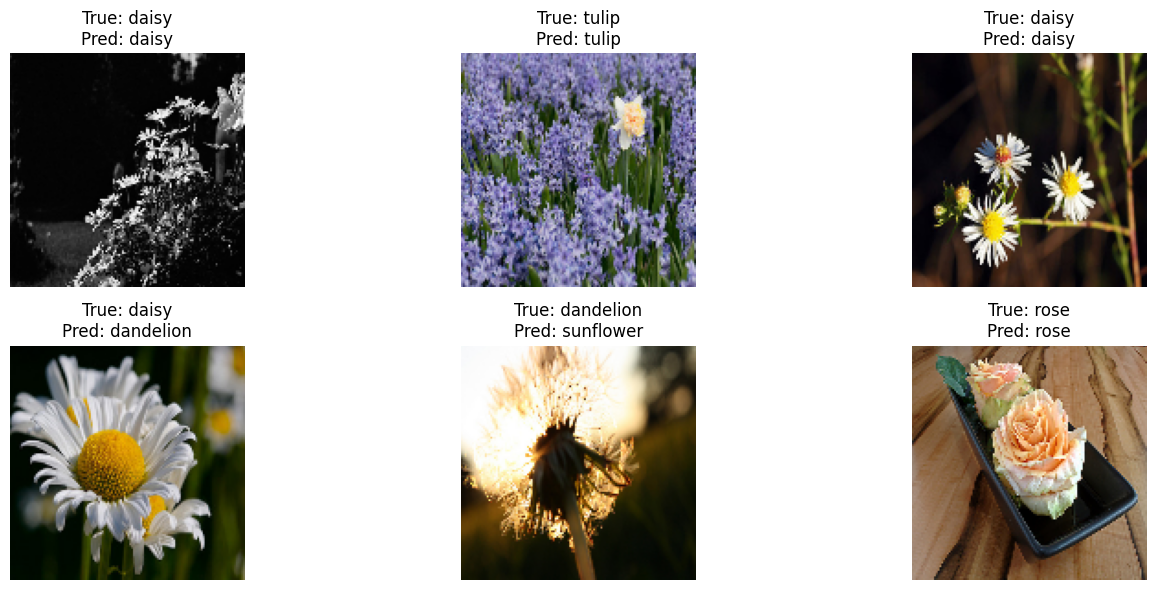

In [ ]:
def show_predictions(model, X_test, y_test, img_test, num_samples=6):
    indices = np.random.choice(range(len(X_test)), num_samples, replace=False)
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        pred_label = label_names[model.predict([X_test[idx]])[0]]
        true_label = label_names[y_test[idx]]
        plt.subplot(2, 3, i + 1)
        plt.imshow(img_test[idx])
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(knn, X_test, y_test, img_test)